From SAV to LOVE

# HW №4


Необходимо скачать и подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks для обучения модели на сегментацию губ (обратите внимание, что сегментация подразумевает уже два класса: фон и губы).     

И затем обучить Модель на выбор из segmentation_models_pytorch     

*(Усложненное задание) Переделайте архитектуру декодера Unet так, как в этой работе https://www.ics.uci.edu/~haoyum3/papers/slides_icivc.pdf. Эта тема пересекается с темой о второго вебинара о LSTM-сетях. И попробуйте обучить получившуюся нейронную сеть.


## Подготовка окружения

In [ ]:
pip install segmentation-models-pytorch

     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 61kB 6.1MB/s 
     |████████████████████████████████| 245kB 21.4MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-none-any.whl size=12420 sha256=0c580222a64e1bb0006f4c7e53661a42bcbe1d044be1acad283a458e6e40b2cd
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60963 sha256=f5854caef1683915faeee282b9aa766e83bfa3aca051aff57039c76bad9865e3
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels


## Обеспечим возможность работы с файлами через гугль диск

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH = 'gdrive/My Drive/AI/GB/PyTorch/'
PATH_L4 = PATH + 'Lesson4/'
DATA_PATH = PATH + 'data/'

In [ ]:
import os
from zipfile import ZipFile
from PIL import Image
import numpy as np
import pandas as pd
import math

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch
from torch.nn import functional as F

########### Вывод изображений и сохранение ################################
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

## Функции из предоставленного ноутбука   

In [ ]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Загрузка датасета

In [ ]:
zip_file_path = DATA_PATH + 'makeup/archive.zip'

In [ ]:
with ZipFile(zip_file_path) as zip_f:
  list_path = zip_f.infolist()[28594].filename
  data_info = pd.read_csv(zip_f.open(zip_f.infolist()[28594].filename))
data_info.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


### Пропускаем если уже есть подготовленный csv файл

In [ ]:
with ZipFile(zip_file_path) as zip_f:
  files = [i.filename[27:] for i in zip_f.infolist()]

In [ ]:
files[-5:]

['mask00028590.png',
 'mask00028591.png',
 'mask00028592.png',
 'mask00028593.png',
 'mask00028594.png']

In [ ]:
to_drop = []
for i in data_info.index:
  if data_info.loc[i, 'filename'] not in files:
    to_drop.append(i)

In [ ]:
to_drop

In [ ]:
to_drop = []
for i in data_info.index:
  if data_info.loc[i, 'mask'] not in files:
    to_drop.append(i)

In [ ]:
len(to_drop)

In [ ]:
print(data_info.shape[0])
data_info.drop(index=to_drop, inplace=True)
data_info.reset_index(inplace=True)
print(data_info.shape[0])

In [ ]:
data_info.tail()

In [ ]:
data_info['im_place'] = 0
data_info['mask_place'] = 0
main_prefix = 'set-lipstick-original/'
image_prefix = 'set-lipstick-original/720p/'
mask_prefix = 'set-lipstick-original/mask/'
with ZipFile(zip_file_path) as zip_f:
  for index in data_info.index:
    data_info.loc[index, 'im_place'] = zip_f.namelist().index(image_prefix + data_info.loc[index, 'filename'])
    data_info.loc[index, 'mask_place'] = zip_f.namelist().index(mask_prefix + data_info.loc[index, 'mask'])
data_info.to_csv(PATH_L4 + 'data_info.csv')
data_info.tail()

### Загружаем из файла

In [ ]:
data_info = pd.read_csv(PATH_L4 + 'data_info.csv', index_col=0)
data_info.tail()

,index,filename,width,height,class,xmin,ymin,xmax,ymax,mask,im_place,mask_place
28535,28589,image00028590.jpg,1280,720,Lips,657,347,817,450,mask00028590.png,28589,57130
28536,28590,image00028591.jpg,1280,720,Lips,713,325,884,388,mask00028591.png,28590,57131
28537,28591,image00028592.jpg,1280,720,Lips,659,401,808,488,mask00028592.png,28591,57132
28538,28592,image00028593.jpg,1280,720,Lips,689,334,839,431,mask00028593.png,28592,57133
28539,28593,image00028594.jpg,1280,720,Lips,657,381,817,476,mask00028594.png,28593,57134


### Смотрим примеры картинок и пишем Dataset

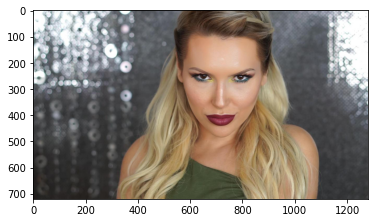

(720, 1280, 3)


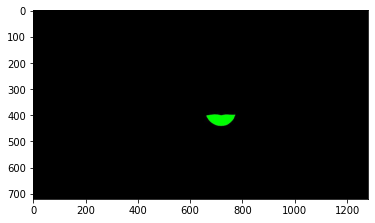

(720, 1280, 3)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  82  83  85  86  87  88  89  90  91
  92  93  95  96  97  99 100 101 102 103 104 105 106 109 110 112 113 114
 115 117 118 121 123 125 126 127 128 129 130 132 133 134 135 136 139 141
 142 145 150 151 152 153 154 156 157 158 159 161 163 164 171 172 174 175
 178 183 184 185 186 187 188 189 190 192 193 194 195 197 198 199 200 201
 202 203 204 206 207 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239
 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255]


In [ ]:
with ZipFile(zip_file_path) as zip_f:
  shift = 28594 + 1
  image = Image.open(zip_f.open(zip_f.infolist()[0].filename))
  plt.imshow(image)
  plt.show()
  np_image = np.asarray(image)
  print(np_image.shape)
  mask = Image.open(zip_f.open(zip_f.infolist()[0 + shift].filename))
  plt.imshow(mask)
  plt.show()
  np_mask = np.asarray(mask)
  print(np_mask.shape)
  print(np.unique(np_mask))

In [ ]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info, zip_file_path, preprocessing=None):
      self.zip_file_path = zip_file_path     
      self.data_info = data_info
      self.data_len = self.data_info.shape[0]
      self.preprocessing = preprocessing

    def __getitem__(self, index):
      with ZipFile(self.zip_file_path) as zip_f:
        image = Image.open(zip_f.open(zip_f.infolist()[self.data_info.loc[index, 'im_place']].filename))
        mask = Image.open(zip_f.open(zip_f.infolist()[self.data_info.loc[index, 'mask_place']].filename))

      image = image.resize((64,64))
      image = np.asarray(image).astype('float')
      if self.preprocessing:
        image = self.preprocessing(image)
      image = torch.as_tensor(image)/255
      image = image.permute(2,0,1)
          # print('image.size: ', image.size())
          # print('image size before unsqueeze: ', image.size())
          # image = image.unsqueeze(0).unsqueeze(0)
          # print('image size before interpolate: ', image.size())
          # image = F.interpolate(input=image, size=256, align_corners=False, mode='bicubic')
          # image=image.squeeze(0).squeeze(0)
      
      mask = mask.resize((64,64))
      mask = np.asarray(mask).astype('float')
      if self.preprocessing:
        mask = self.preprocessing(mask)
      mask = np.rint(mask.mean(axis=2)!= 0)
      mask = torch.as_tensor(mask)
          # mask = mask.permute(2,0,1)
          # print('mask.size: ', mask.size())
          # mask = mask.unsqueeze(0).unsqueeze(0)
          # mask = F.interpolate(input=mask, size=256, mode='nearest')
          # mask=mask.squeeze(0).squeeze(0)

      return (image.float(), mask.int())

    def __len__(self):
        return self.data_len

In [ ]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if len(image.shape) > 2:
          image = image.permute(1, 2, 0)
        plt.imshow(image)
    plt.show()

image.size:  torch.Size([3, 64, 64])
(mask.size:  torch.Size([64, 64])


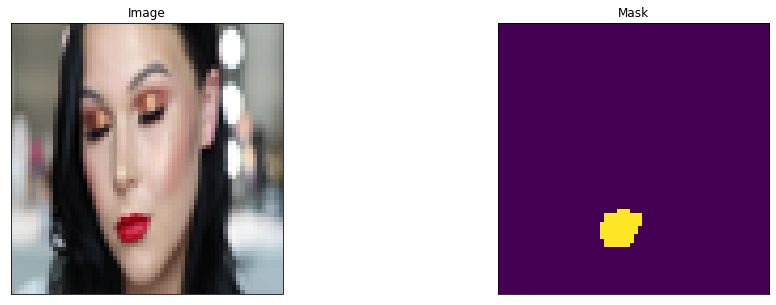

In [ ]:
data = CustomDatasetFromImages(data_info, zip_file_path)
image, mask = data[4321] # get some sample
print('image.size: ', image.size())
print('(mask.size: ', mask.size())
visualize(
    image=image, 
    mask=mask,
)

### Дополнительная чистка данных

Так как обучение вылетает на какой-то картинке из-за несовпадения размеров, поищем предателя

In [ ]:
for i in range(600,1000):
  try:
    image, mask = data[i]
  except:
    print('exception: ', i)
  if image.size() != torch.Size([3, 64, 64]):
    print('image issue: ', i)
  if mask.size() != torch.Size([64, 64]):
    print('mask issue: ', i)
  if i%100 == 0:
    print(i)

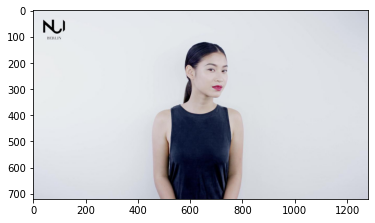

(720, 1280, 3)


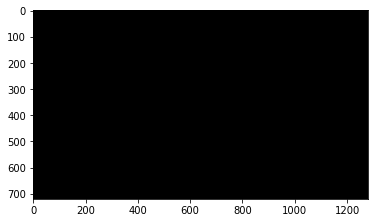

(720, 1280)
[False]
0


In [ ]:
with ZipFile(zip_file_path) as zip_f:
  image = Image.open(zip_f.open(zip_f.infolist()[615].filename))
  plt.imshow(image)
  plt.show()
  np_image = np.asarray(image)
  print(np_image.shape)
  mask = Image.open(zip_f.open(zip_f.infolist()[29210].filename))
  plt.imshow(mask)
  plt.show()
  np_mask = np.asarray(mask)
  print(np_mask.shape)
  print(np.unique(np_mask))
  print(np_mask.sum())

In [ ]:
with ZipFile(zip_file_path) as zip_f:
  issues = []
  for index in data_info.index:
    mask = Image.open(zip_f.open(zip_f.infolist()[data_info.loc[index, 'mask_place']].filename))
    np_mask = np.asarray(mask)
    if np_mask.sum() == 0:
      print('zero zum index: ', index)
      issues.append(index)
    if index%1000 == 0:
      print(index)
print(data_info.shape[0])
data_info.drop(index=issues, inplace=True)
data_info.reset_index(inplace=True)
print(data_info.shape[0])
data_info.to_csv(PATH_L4 + 'data_info_cleaned.csv')
data_info.tail()

0
zero zum index:  615
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
28540
28539


,level_0,index,filename,width,height,class,xmin,ymin,xmax,ymax,mask,im_place,mask_place
28534,28535,28589,image00028590.jpg,1280,720,Lips,657,347,817,450,mask00028590.png,28589,57130
28535,28536,28590,image00028591.jpg,1280,720,Lips,713,325,884,388,mask00028591.png,28590,57131
28536,28537,28591,image00028592.jpg,1280,720,Lips,659,401,808,488,mask00028592.png,28591,57132
28537,28538,28592,image00028593.jpg,1280,720,Lips,689,334,839,431,mask00028593.png,28592,57133
28538,28539,28593,image00028594.jpg,1280,720,Lips,657,381,817,476,mask00028594.png,28593,57134


Предатель был только один, а столько крови попортил

In [ ]:
data_info = pd.read_csv(PATH_L4 + 'data_info_cleaned.csv', index_col=0)
data_info.tail()

,level_0,index,filename,width,height,class,xmin,ymin,xmax,ymax,mask,im_place,mask_place
28534,28535,28589,image00028590.jpg,1280,720,Lips,657,347,817,450,mask00028590.png,28589,57130
28535,28536,28590,image00028591.jpg,1280,720,Lips,713,325,884,388,mask00028591.png,28590,57131
28536,28537,28591,image00028592.jpg,1280,720,Lips,659,401,808,488,mask00028592.png,28591,57132
28537,28538,28592,image00028593.jpg,1280,720,Lips,689,334,839,431,mask00028593.png,28592,57133
28538,28539,28593,image00028594.jpg,1280,720,Lips,657,381,817,476,mask00028594.png,28593,57134


## Обучение

In [ ]:
data_info = pd.read_csv(PATH_L4 + 'data_info_cleaned.csv', index_col=0)
data_info.tail()

,level_0,index,filename,width,height,class,xmin,ymin,xmax,ymax,mask,im_place,mask_place
28534,28535,28589,image00028590.jpg,1280,720,Lips,657,347,817,450,mask00028590.png,28589,57130
28535,28536,28590,image00028591.jpg,1280,720,Lips,713,325,884,388,mask00028591.png,28590,57131
28536,28537,28591,image00028592.jpg,1280,720,Lips,659,401,808,488,mask00028592.png,28591,57132
28537,28538,28592,image00028593.jpg,1280,720,Lips,689,334,839,431,mask00028593.png,28592,57133
28538,28539,28593,image00028594.jpg,1280,720,Lips,657,381,817,476,mask00028594.png,28593,57134


In [ ]:
import segmentation_models_pytorch as smp
model = smp.Unet('resnet34', in_channels = 3, classes=1).to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
from segmentation_models_pytorch.encoders import get_preprocessing_fn

In [ ]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(data_info, test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train, zip_file_path, preprocessing=get_preprocessing_fn('resnet34', pretrained='imagenet'))
test_data = CustomDatasetFromImages(X_test, zip_file_path, preprocessing=get_preprocessing_fn('resnet34', pretrained='imagenet'))

In [ ]:
train_data_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=4, shuffle=False)

In [ ]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]


optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])

### Первая эпоха (пропустить после исполнения)

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [ ]:
# train model for 10 epochs
max_score = 0

for i in range(0, 3):
    
  print('\nEpoch: {}'.format(i))
  train_logs = train_epoch.run(train_data_loader)
  torch.save(model, PATH_L4 + f'model_epoch_{i}.pth')

  valid_logs = valid_epoch.run(test_data_loader)
  
  if max_score < valid_logs['iou_score']:
      max_score = valid_logs['iou_score']
      torch.save(model, PATH_L4 + 'best_model.pth')
      print('Model saved!')
      
  # if i == 25:
  #     optimizer.param_groups[0]['lr'] = 1e-5
  #     print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 2141/2141 [1:17:09<00:00,  2.16s/it, dice_loss - -6.876, iou_score - 7.652e+07]
Model saved!

Epoch: 1
train:  64%|██████▍   | 1610/2498 [1:54:51<1:02:59,  4.26s/it, dice_loss - -14.82, iou_score - -1.333]

### Вторая эпоха (пропустить после исполнения)

In [ ]:
model = torch.load(PATH_L4 + 'best_model.pth')

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [ ]:
# train model for 10 epochs
max_score = 0

for i in range(1, 3):
    
  print('\nEpoch: {}'.format(i))
  train_logs = train_epoch.run(train_data_loader)
  torch.save(model, PATH_L4 + f'model_epoch_{i}.pth')

  valid_logs = valid_epoch.run(test_data_loader)
  
  if max_score < valid_logs['iou_score']:
      max_score = valid_logs['iou_score']
      torch.save(model, PATH_L4 + 'best_model.pth')
      print('Model saved!')

## Отрисовка результата

In [ ]:
model = torch.load(PATH_L4 + 'best_model.pth').to(device)

In [ ]:
data = CustomDatasetFromImages(data_info, zip_file_path)
preprocessed_data = CustomDatasetFromImages(data_info, zip_file_path, preprocessing=get_preprocessing_fn('resnet34', pretrained='imagenet'))

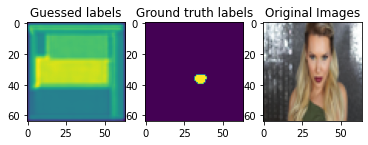

<Figure size 432x288 with 0 Axes>

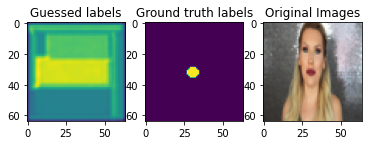

<Figure size 432x288 with 0 Axes>

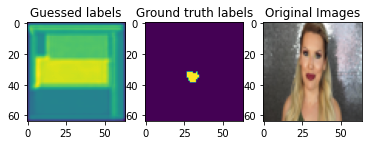

<Figure size 432x288 with 0 Axes>

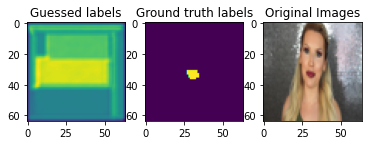

<Figure size 432x288 with 0 Axes>

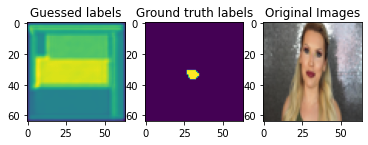

<Figure size 432x288 with 0 Axes>

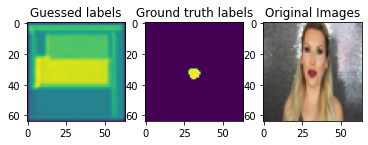

<Figure size 432x288 with 0 Axes>

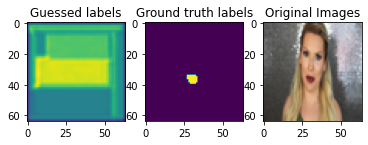

<Figure size 432x288 with 0 Axes>

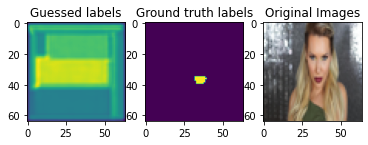

<Figure size 432x288 with 0 Axes>

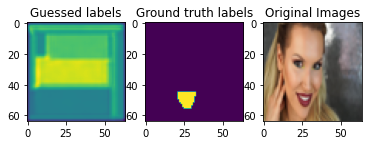

<Figure size 432x288 with 0 Axes>

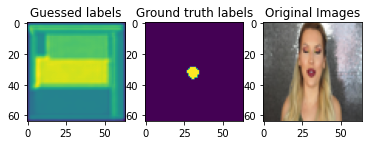

<Figure size 432x288 with 0 Axes>

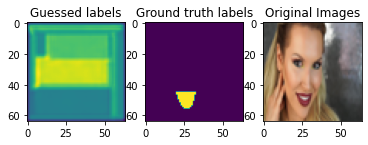

<Figure size 432x288 with 0 Axes>

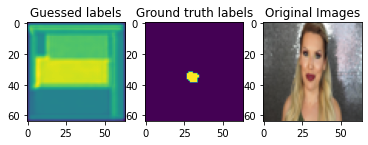

<Figure size 432x288 with 0 Axes>

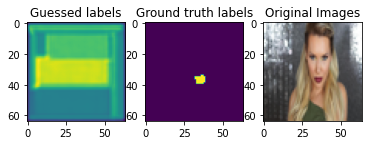

<Figure size 432x288 with 0 Axes>

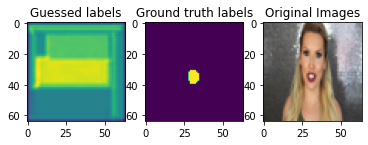

<Figure size 432x288 with 0 Axes>

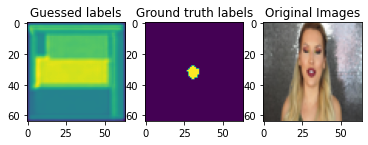

<Figure size 432x288 with 0 Axes>

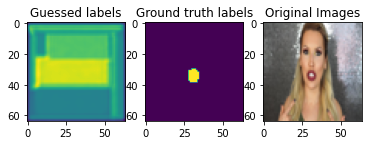

<Figure size 432x288 with 0 Axes>

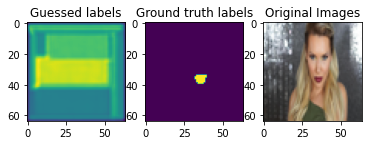

<Figure size 432x288 with 0 Axes>

In [ ]:
for i in range(len(data)):
  f, axarr = plt.subplots(1,3)
  image, mask = data[i]

  image = image.permute(1, 2, 0)
  axarr[2].imshow(image)
  axarr[2].set_title('Original Images')

  axarr[1].imshow(mask)
  axarr[1].set_title('Ground truth labels')

  data_loader = DataLoader(preprocessed_data[i], batch_size=1)
  preprocessed_image, _ = data_loader
  output = model(preprocessed_image.to(device))
  axarr[0].imshow(output.squeeze().squeeze().detach().cpu().numpy())
  axarr[0].set_title('Guessed labels')

  plt.show()
  plt.gcf().show()

  if i > 15:
    break